## Introduction ##
Hello! This is my first Kaggle notebook. I hope you like it. I'm from Argentina and I want to get some experience while I have some fun with the NCAA March Madness.

The competition is called [March Machine Learning Mania 2017](https://www.kaggle.com/c/march-machine-learning-mania-2017) and the idea is to create a model that predict 2017 NCAA tournament results with the smallest log loss. So let's start.

In [486]:
#Added by me
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


## Processing data ##
### Data comparison ###
First, I had to decide the data to be used. It seems to me that using Season matches will not be a good idea: they have different mechanics and rivals are not the same than in tournaments in most cases. Albrecht Zimmerman's work helped me a bit with the abstract of his [Basketball predictions in the NCAAB and NBA: Similarities and differences](http://onlinelibrary.wiley.com/doi/10.1002/sam.11319/abstract). I could not afford the journal but in the abstract we have "the NCAAB regular season is not ideal for training to predict its post-season". So, we are going to work with Tournament matches.

In [487]:
tourney_data=pd.read_csv("../data/TourneyDetailedResults.csv")
tourney_data.shape

(914, 34)

On the other hand, we had detailed information from 2003 to 2017. My other question was if statistics had changed in some way. I did not want to spend a lot of time on this but I plot some data. It looks stable, excepting a rare year in 2009 (please NCAA fans correct me if you have). Here we have two of them:

In [488]:
%matplotlib inline

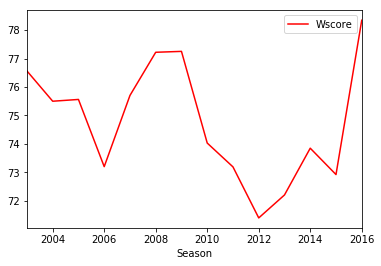

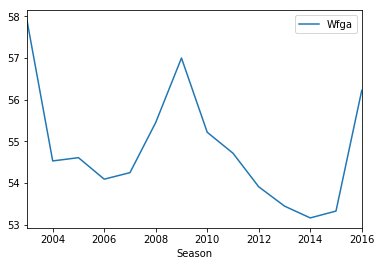

In [489]:
tourney_data=tourney_data.groupby(['Season']).mean()

tourney_data.plot(y='Wscore',color='r')
tourney_data.plot(y='Wfga')

# Feature Engineering #
The data is chosen so we have to work on it. I am going to take season data from each season and create some common features on basketball statistics for each tournament team.

In [490]:
detailed_data=pd.read_csv("../data/TourneyDetailedResults.csv")

training_data = pd.DataFrame()
training_data[["Season","team1", "team2"]] =detailed_data[["Season","Wteam", "Lteam"]].copy()
training_data["pred"] = 1

seeds_data=pd.read_csv("../data/TourneyFutureResults.csv")
seeds_data["pred"]=1

for index, row in training_data.iterrows():
    if random.randint(0,1)==1:
        temp=row['team1']
        training_data.set_value(index,'team1',row['team2'])
        training_data.set_value(index,'team2',temp)
        training_data.set_value(index,'pred',0)
        
training_data=pd.concat((training_data,seeds_data),axis=0).reset_index().drop("index",axis=1)

#Method to add new feature to the dataframe.
def loadInTraining(name,data):
    new_training_data=pd.merge(training_data,data,how="inner",left_on=["Season","team1"], right_on=["Season","team"])
    new_training_data=new_training_data.drop("team",axis=1)
    new_training_data=new_training_data.rename(columns={name: name+"1"})
    
    new_training_data=pd.merge(new_training_data,data,how="inner",left_on=["Season","team2"], right_on=["Season","team"])
    new_training_data=new_training_data.drop("team",axis=1)
    new_training_data=new_training_data.rename(columns={name: name+"2"})
    
    return new_training_data
training_data.shape

(950, 4)

**PPG - Points Per Game**

First and simplest feature.

In [491]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

ppg_data_a=pd.DataFrame()
ppg_data_a[["Season","team","score"]]=season_data[["Season","Wteam","Wscore"]]
ppg_data_b=pd.DataFrame()
ppg_data_b[["Season","team","score"]]=season_data[["Season","Lteam","Lscore"]]

ppg_data=pd.concat((ppg_data_a,ppg_data_b),axis=0)
ppg_data=ppg_data.groupby(["Season","team"])["score"].agg(['sum','count']).reset_index()
ppg_data["PPG"]=ppg_data["sum"]/ppg_data["count"]

ppg_data=ppg_data[["Season","team","PPG"]]
training_data=loadInTraining("PPG",ppg_data)
training_data.head()


,Season,team1,team2,pred,PPG1,PPG2
0,2003,1411,1421,0,72.800000,71.206897
1,2003,1400,1421,1,78.857143,71.206897
2,2003,1436,1112,0,67.793103,85.214286
3,2003,1211,1112,0,77.064516,85.214286
4,2003,1242,1112,1,81.333333,85.214286


**RPG - Received Per Game**

In [492]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

rpg_data_a=pd.DataFrame()
rpg_data_a[["Season","team","score"]]=season_data[["Season","Wteam","Lscore"]]
rpg_data_b=pd.DataFrame()
rpg_data_b[["Season","team","score"]]=season_data[["Season","Lteam","Wscore"]]

rpg_data=pd.concat((rpg_data_a,rpg_data_b),axis=0)
rpg_data=rpg_data.groupby(["Season","team"])["score"].agg(['sum','count']).reset_index()
rpg_data["RPG"]=rpg_data["sum"]/rpg_data["count"]

rpg_data=rpg_data[["Season","team","RPG"]]
training_data=loadInTraining("RPG",rpg_data)
training_data.head()


,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000


**REC - Record (W/L)**

Here we have the first (spoiler alert) important feature. Percentage of winning in the season.

In [493]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

rec_data_w=pd.DataFrame()
rec_data_w[["Season","team","W"]]=season_data[["Season","Wteam","Wscore"]]
rec_data_l=pd.DataFrame()
rec_data_l[["Season","team","L"]]=season_data[["Season","Lteam","Lscore"]]

rec_data_w=rec_data_w.groupby(["Season","team"])["W"].count().reset_index()
rec_data_l=rec_data_l.groupby(["Season","team"])["L"].count().reset_index()
rec_data=pd.merge(rec_data_w,rec_data_l,how="outer",on=["Season","team"])
rec_data=rec_data.fillna(0)
rec_data["REC"]=rec_data["W"]/(rec_data["W"]+rec_data["L"])

rec_data=rec_data[["Season","team","REC"]]

training_data=loadInTraining("REC",rec_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857


**eFG% - Effective Field Goal Percentage**

After using those that ocurred to me, I started looking at the theory. So I used the [Four Factors of Basketball Success by Dean Oliver](http://www.basketball-reference.com/about/factors.html). I used every offensive feature and some of the defensive ones. Oliver identified also the importance of each feature (40% is about Shooting while 15% is about Free Throws, for example) but I'm afraid that does not count on my model (see Random Forest reduction).

In [494]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

efg_data_w=pd.DataFrame()
efg_data_w[["Season","team","fga","fg","3p"]]=season_data[["Season","Wteam","Wfga","Wfgm","Wfgm3"]]
efg_data_l=pd.DataFrame()
efg_data_l[["Season","team","fga","fg","3p"]]=season_data[["Season","Lteam","Lfga","Lfgm","Lfgm3"]]

efg_data=pd.concat((efg_data_w,efg_data_l),axis=0)
efg_data=efg_data.groupby(["Season","team"]).sum().reset_index()
efg_data["eFG%"]=(efg_data["fg"]+0.5*efg_data["3p"])/efg_data["fga"]

efg_data=efg_data[["Season","team","eFG%"]]
training_data=loadInTraining("eFG%",efg_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,eFG%1,eFG%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,0.501206,0.486339
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,0.495423,0.486339
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,0.495423,0.483585
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,0.495423,0.498737
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,0.491667,0.514946


**dFG% - Effective Defensive Field Goal Percentage**

In [495]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

efg_data_w=pd.DataFrame()
efg_data_w[["Season","team","fga","fg","3p"]]=season_data[["Season","Wteam","Lfga","Lfgm","Lfgm3"]]
efg_data_l=pd.DataFrame()
efg_data_l[["Season","team","fga","fg","3p"]]=season_data[["Season","Lteam","Wfga","Wfgm","Wfgm3"]]

efg_data=pd.concat((efg_data_w,efg_data_l),axis=0)
efg_data=efg_data.groupby(["Season","team"]).sum().reset_index()
efg_data["dFG%"]=(efg_data["fg"]+0.5*efg_data["3p"])/efg_data["fga"]

efg_data=efg_data[["Season","team","dFG%"]]
training_data=loadInTraining("dFG%",efg_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,eFG%1,eFG%2,dFG%1,dFG%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,0.501206,0.486339,0.487307,0.518382
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,0.495423,0.486339,0.462907,0.518382
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,0.495423,0.483585,0.462907,0.463958
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,0.495423,0.498737,0.462907,0.458013
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,0.491667,0.514946,0.477458,0.456378


**TOV% - Turnover Percentage**

In [496]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

tov_data_w=pd.DataFrame()
tov_data_w[["Season","team","fga","fta","tov"]]=season_data[["Season","Wteam","Wfga","Wfta","Wto"]]
tov_data_l=pd.DataFrame()
tov_data_l[["Season","team","fga","fta","tov"]]=season_data[["Season","Lteam","Lfga","Lfta","Lto"]]

tov_data=pd.concat((tov_data_w,tov_data_l),axis=0)
tov_data=tov_data.groupby(["Season","team"]).sum().reset_index()
tov_data["TOV%"]=tov_data["tov"]/(tov_data["fga"]+0.44*tov_data["fta"]+tov_data["tov"])

tov_data=tov_data[["Season","team","TOV%"]]
training_data=loadInTraining("TOV%",tov_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,eFG%1,eFG%2,dFG%1,dFG%2,TOV%1,TOV%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,0.501206,0.486339,0.487307,0.518382,0.183868,0.197141
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,0.495423,0.486339,0.462907,0.518382,0.155562,0.197141
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,0.495423,0.483585,0.462907,0.463958,0.155562,0.173998
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,0.495423,0.498737,0.462907,0.458013,0.155562,0.192996
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,0.491667,0.514946,0.477458,0.456378,0.179145,0.161593


**dTO% - Defensive Turnover Percentage**

In [497]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

tov_data_w=pd.DataFrame()
tov_data_w[["Season","team","fga","fta","tov"]]=season_data[["Season","Wteam","Lfga","Lfta","Lto"]]
tov_data_l=pd.DataFrame()
tov_data_l[["Season","team","fga","fta","tov"]]=season_data[["Season","Lteam","Wfga","Wfta","Wto"]]

tov_data=pd.concat((tov_data_w,tov_data_l),axis=0)
tov_data=tov_data.groupby(["Season","team"]).sum().reset_index()
tov_data["dTO%"]=tov_data["tov"]/(tov_data["fga"]+0.44*tov_data["fta"]+tov_data["tov"])

tov_data=tov_data[["Season","team","dTO%"]]
training_data=loadInTraining("dTO%",tov_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,eFG%1,eFG%2,dFG%1,dFG%2,TOV%1,TOV%2,dTO%1,dTO%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,0.501206,0.486339,0.487307,0.518382,0.183868,0.197141,0.172741,0.153228
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,0.495423,0.486339,0.462907,0.518382,0.155562,0.197141,0.171553,0.153228
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,0.495423,0.483585,0.462907,0.463958,0.155562,0.173998,0.171553,0.205376
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,0.495423,0.498737,0.462907,0.458013,0.155562,0.192996,0.171553,0.193795
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,0.491667,0.514946,0.477458,0.456378,0.179145,0.161593,0.173327,0.188706


**ORB% - Offensive Rebound Percentage**

In [498]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

orb_data_w=pd.DataFrame()
orb_data_w[["Season","team","or","odr"]]=season_data[["Season","Wteam","Wor","Ldr"]]
orb_data_l=pd.DataFrame()
orb_data_l[["Season","team","or","odr"]]=season_data[["Season","Lteam","Lor","Wdr"]]

orb_data=pd.concat((orb_data_w,orb_data_l),axis=0)
orb_data=orb_data.groupby(["Season","team"]).sum().reset_index()
orb_data["ORB%"]=orb_data["or"]/(orb_data["or"]+orb_data["odr"])

orb_data=orb_data[["Season","team","ORB%"]]
training_data=loadInTraining("ORB%",orb_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,eFG%1,eFG%2,dFG%1,dFG%2,TOV%1,TOV%2,dTO%1,dTO%2,ORB%1,ORB%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,0.501206,0.486339,0.487307,0.518382,0.183868,0.197141,0.172741,0.153228,0.365402,0.349705
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,0.495423,0.486339,0.462907,0.518382,0.155562,0.197141,0.171553,0.153228,0.423761,0.349705
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,0.495423,0.483585,0.462907,0.463958,0.155562,0.173998,0.171553,0.205376,0.423761,0.306962
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,0.495423,0.498737,0.462907,0.458013,0.155562,0.192996,0.171553,0.193795,0.423761,0.345511
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,0.491667,0.514946,0.477458,0.456378,0.179145,0.161593,0.173327,0.188706,0.372277,0.394615


**DRB% - Defensive Rebound Percentage**

In [499]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

drb_data_w=pd.DataFrame()
drb_data_w[["Season","team","dr","oor"]]=season_data[["Season","Wteam","Wdr","Lor"]]
drb_data_l=pd.DataFrame()
drb_data_l[["Season","team","dr","oor"]]=season_data[["Season","Lteam","Ldr","Wor"]]

drb_data=pd.concat((drb_data_w,drb_data_l),axis=0)
drb_data=drb_data.groupby(["Season","team"]).sum().reset_index()
drb_data["DRB%"]=drb_data["dr"]/(drb_data["dr"]+drb_data["oor"])

drb_data=drb_data[["Season","team","DRB%"]]
training_data=loadInTraining("DRB%",drb_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,...,dFG%1,dFG%2,TOV%1,TOV%2,dTO%1,dTO%2,ORB%1,ORB%2,DRB%1,DRB%2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,...,0.487307,0.518382,0.183868,0.197141,0.172741,0.153228,0.365402,0.349705,0.675136,0.628037
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,...,0.462907,0.518382,0.155562,0.197141,0.171553,0.153228,0.423761,0.349705,0.669104,0.628037
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,...,0.462907,0.463958,0.155562,0.173998,0.171553,0.205376,0.423761,0.306962,0.669104,0.687958
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,...,0.462907,0.458013,0.155562,0.192996,0.171553,0.193795,0.423761,0.345511,0.669104,0.722382
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,...,0.477458,0.456378,0.179145,0.161593,0.173327,0.188706,0.372277,0.394615,0.728516,0.678352


**FTR - Free Throw Rate**

In [500]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

ftr_data_w=pd.DataFrame()
ftr_data_w[["Season","team","ft","fga"]]=season_data[["Season","Wteam","Wftm","Wfga"]]
ftr_data_l=pd.DataFrame()
ftr_data_l[["Season","team","ft","fga"]]=season_data[["Season","Lteam","Lftm","Lfga"]]

ftr_data=pd.concat((ftr_data_w,ftr_data_l),axis=0)
ftr_data=ftr_data.groupby(["Season","team"]).sum().reset_index()
ftr_data["FTR"]=ftr_data["ft"]/ftr_data["fga"]

ftr_data=ftr_data[["Season","team","FTR"]]
training_data=loadInTraining("FTR",ftr_data)
training_data.head()


,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,...,TOV%1,TOV%2,dTO%1,dTO%2,ORB%1,ORB%2,DRB%1,DRB%2,FTR1,FTR2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,...,0.183868,0.197141,0.172741,0.153228,0.365402,0.349705,0.675136,0.628037,0.314837,0.281117
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,...,0.155562,0.197141,0.171553,0.153228,0.423761,0.349705,0.669104,0.628037,0.272311,0.281117
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,...,0.155562,0.173998,0.171553,0.205376,0.423761,0.306962,0.669104,0.687958,0.272311,0.351937
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,...,0.155562,0.192996,0.171553,0.193795,0.423761,0.345511,0.669104,0.722382,0.272311,0.318182
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,...,0.179145,0.161593,0.173327,0.188706,0.372277,0.394615,0.728516,0.678352,0.230247,0.266848


**SdN - Seed Number**

Finally, a few more features taken by basketball statistics, I came to seeds. I have to say that my model has appreciated the subjectivity of seeding. Accuracy really improves reaching around 70% after this feature.

In [501]:
seed_data=pd.read_csv("../data/TourneySeeds.csv")

seed_data["SdN"]=[int(str(x)[1:3]) for x in seed_data["Seed"]]
seed_data["team"]=seed_data["Team"]

seed_data=seed_data[["Season","team","SdN"]]
seed_data=seed_data.reset_index().drop("index",axis=1)
training_data=loadInTraining("SdN",seed_data)
training_data.head()


,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,...,dTO%1,dTO%2,ORB%1,ORB%2,DRB%1,DRB%2,FTR1,FTR2,SdN1,SdN2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,...,0.172741,0.153228,0.365402,0.349705,0.675136,0.628037,0.314837,0.281117,16,16
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,...,0.171553,0.153228,0.423761,0.349705,0.669104,0.628037,0.272311,0.281117,1,16
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,...,0.171553,0.205376,0.423761,0.306962,0.669104,0.687958,0.272311,0.351937,1,9
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,...,0.171553,0.193795,0.423761,0.345511,0.669104,0.722382,0.272311,0.318182,1,7
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,...,0.173327,0.188706,0.372277,0.394615,0.728516,0.678352,0.230247,0.266848,16,1


**dFT - Defensive Free Throw Rate**

In [502]:
season_data=pd.read_csv("../data/RegularSeasonDetailedResults.csv")

ftr_data_w=pd.DataFrame()
ftr_data_w[["Season","team","ft","fga"]]=season_data[["Season","Wteam","Lftm","Lfga"]]
ftr_data_l=pd.DataFrame()
ftr_data_l[["Season","team","ft","fga"]]=season_data[["Season","Lteam","Wftm","Wfga"]]

ftr_data=pd.concat((ftr_data_w,ftr_data_l),axis=0)
ftr_data=ftr_data.groupby(["Season","team"]).sum().reset_index()
ftr_data["dFT"]=ftr_data["ft"]/ftr_data["fga"]

ftr_data=ftr_data[["Season","team","dFT"]]
training_data=loadInTraining("dFT",ftr_data)
training_data.head()

,Season,team1,team2,pred,PPG1,PPG2,RPG1,RPG2,REC1,REC2,...,ORB%1,ORB%2,DRB%1,DRB%2,FTR1,FTR2,SdN1,SdN2,dFT1,dFT2
0,2003,1411,1421,0,72.800000,71.206897,70.833333,78.448276,0.600000,0.448276,...,0.365402,0.349705,0.675136,0.628037,0.314837,0.281117,16,16,0.198124,0.250000
1,2003,1400,1421,1,78.857143,71.206897,68.678571,78.448276,0.785714,0.448276,...,0.423761,0.349705,0.669104,0.628037,0.272311,0.281117,1,16,0.234017,0.250000
2,2003,1400,1345,1,78.857143,71.750000,68.678571,65.250000,0.785714,0.642857,...,0.423761,0.306962,0.669104,0.687958,0.272311,0.351937,1,9,0.234017,0.269332
3,2003,1400,1277,1,78.857143,67.225806,68.678571,60.967742,0.785714,0.612903,...,0.423761,0.345511,0.669104,0.722382,0.272311,0.318182,1,7,0.234017,0.295513
4,2003,1436,1112,0,67.793103,85.214286,63.137931,70.250000,0.655172,0.892857,...,0.372277,0.394615,0.728516,0.678352,0.230247,0.266848,16,1,0.191609,0.173385


## Model sketch ##

The model has changed a lot. I started using Logistic Regression until I tried a K neighbors classifier. That was because I found this: [A Machine Learning Approach to March Madness](http://axon.cs.byu.edu/~martinez/classes/478/stuff/Sample_Group_Project3.pdf). I started working with it so it is a big influence on my work. But at the end, I have really changed a lot of things.

First, I have used random ordering recommendation. I think it has improved my model. 

After that, I finally did not use K-neighbors. I have to work with NN instead. My model was as accurate with K-neighbors as with NN, but I could not turn the log loss down without NN (now around 0.55).

Finally, features used in the paper were not the same. But I tried to apply Random Forest for feature reduction as they do. I left the code I used but I am not using it actually.

In [503]:
training_set=[2003,2004,2006,2008,2009,2011,2013,2015,2016]
val_set=[2005,2014]
test_set=[2010,2012]

X = pd.DataFrame()
X = training_data.loc[training_data["Season"].isin(training_set)].copy()
X = X.reindex_axis(sorted(X.columns), axis=1)

Xval=pd.DataFrame()
Xval = training_data.loc[training_data["Season"].isin(val_set)].copy()
Xval=X.reindex_axis(sorted(X.columns), axis=1)

Xtest=pd.DataFrame()
Xtest=training_data.loc[training_data["Season"].isin(val_set)].copy()
Xtest = Xtest.reindex_axis(sorted(Xtest.columns), axis=1)

Xseeds=pd.DataFrame()
Xseeds=training_data.loc[training_data["Season"] == 2017].copy()
Xseeds = Xseeds.reindex_axis(sorted(Xseeds.columns), axis=1)

y = pd.DataFrame()
y["pred"]=X["pred"]

yval = pd.DataFrame()
yval["pred"]=Xval["pred"]

ytest = pd.DataFrame()
ytest["pred"]=Xtest["pred"]

X = X.drop(["Season","team1","team2","pred"],axis=1)
Xval = Xval.drop(["Season","team1","team2","pred"],axis=1)
Xseeds=Xseeds.drop(["pred"],axis=1)
Xtest = Xtest.drop(["Season","team1","team2","pred"],axis=1)
Xseeds.shape

(36, 27)

I added normalization because of feature differences (points, percentages, etc.).

In [504]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if (str("team") not in feature_name and str("Season") not in feature_name):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value>1:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

X=normalize(X)
Xval=normalize(Xval)
Xtest=normalize(Xtest)
Xseeds=normalize(Xseeds)
Xseeds.head()

,DRB%1,DRB%2,FTR1,FTR2,ORB%1,ORB%2,PPG1,PPG2,REC1,REC2,...,dFG%1,dFG%2,dFT1,dFT2,dTO%1,dTO%2,eFG%1,eFG%2,team1,team2
914,0.675176,0.724587,0.280022,0.310200,0.295390,0.308943,0.215967,0.857798,0.606061,0.593750,...,0.489315,0.521831,0.231781,0.267754,0.193831,0.143037,0.524130,0.540221,1243,1448
915,0.653912,0.672539,0.221570,0.308862,0.229479,0.361863,0.072772,0.145222,0.558824,0.607143,...,0.495844,0.499043,0.219740,0.241709,0.186806,0.194199,0.509343,0.500661,1291,1309
916,0.685470,0.716696,0.240719,0.271605,0.319498,0.295126,0.283535,0.062929,0.733333,0.625000,...,0.451151,0.484392,0.174060,0.238226,0.167220,0.176737,0.517691,0.487093,1300,1413
917,0.719122,0.688376,0.263761,0.275164,0.264273,0.307692,0.153819,0.620840,0.625000,0.727273,...,0.496915,0.497107,0.201907,0.170203,0.181309,0.155813,0.512615,0.519221,1344,1425
918,0.724227,0.653912,0.280348,0.221570,0.296334,0.229479,0.466250,0.000000,0.911765,0.558824,...,0.480649,0.495844,0.155335,0.219740,0.177430,0.186806,0.578661,0.509343,1437,1291


**Feature reduction**

In [505]:
Xforest=X.copy()
yforest=y.copy()
forest=RandomForestClassifier(n_estimators=30)
forest.fit(Xforest,yforest)

table=pd.concat((pd.DataFrame(Xforest.iloc[:, 0:].columns, columns = ['variable']), 
           pd.DataFrame(forest.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20].reset_index()
table=table.drop("index",axis=1)
table=table.groupby([table.variable.str[:3]]).sum().reset_index().sort_values(by='importance',ascending=False).reset_index()
table=table.drop("index",axis=1)
table

/home/juampilorenzo/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,variable,importance
0,SdN,0.167959
1,REC,0.101421
2,PPG,0.093082
3,TOV,0.085015
4,dFT,0.080607
5,ORB,0.069421
6,RPG,0.066471
7,eFG,0.066420
8,dFG,0.043543
9,DRB,0.040021


Just as a comment: seeds are by far the most important feature here. Your winning rate in the season also seems to be really defining here. More about the game, turnovers and offensive rebounds are crucial. It is a bit surprising to me that points per game made shows to be much less important than your received points per game.

In [506]:
def reduction(X,features,cant):
    delete=features.shape[0]-cant
    features=features.sort_values(by="importance",ascending=True).reset_index().drop("index",axis=1)
    for i in range(0,delete):
        pattern=features.loc[i]["variable"]
        col=[col for col in X.columns if str(pattern) in col]
        X=X.drop(col[0],1)
        X=X.drop(col[1],1)
    return X
        
reduct_to=12
X=reduction(X,table,reduct_to)
Xval=reduction(Xval,table,reduct_to)
Xtest=reduction(Xtest,table,reduct_to)
Xseeds=reduction(Xseeds,table,reduct_to)

**Neural Network**

In [507]:
Xnn=X.values
ynn=y.values

In [508]:
#seed = 7
#numpy.random.seed(seed)

model = Sequential()
model.add(Dense(128, input_dim=(reduct_to*2), init='uniform', activation='relu'))
model.add(Dense(128, init='uniform', activation='relu'))
model.add(Dense(64, init='uniform', activation='relu'))
model.add(Dense(32, init='uniform', activation='relu'))
model.add(Dense(1, init='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.fit(Xnn, ynn, nb_epoch=150, batch_size=32)


Epoch 1/150
588/588 [==============================] - 0s - loss: 0.6931 - acc: 0.5119     
Epoch 2/150
588/588 [==============================] - 0s - loss: 0.6916 - acc: 0.6344     
Epoch 3/150
588/588 [==============================] - 0s - loss: 0.6771 - acc: 0.6531     
Epoch 4/150
588/588 [==============================] - 0s - loss: 0.6197 - acc: 0.6905     
Epoch 5/150
588/588 [==============================] - 0s - loss: 0.5903 - acc: 0.6922     
Epoch 6/150
588/588 [==============================] - 0s - loss: 0.5797 - acc: 0.6939     

In [509]:
val=model.evaluate(Xval.values, yval.values)[1]
probs = model.predict(Xval.values)
val

 32/588 [>.............................] - ETA: 2s

0.73129251660132899

##  Test set ##

In [510]:
predict_test=model.evaluate(Xtest.values, ytest.values)[1]
probs = model.predict(Xtest.values)
predict_test

 32/131 [======>.......................] - ETA: 0s

0.68702290121835607

Here we get the model log loss, parameter used to compite in the competition.

In [511]:
ytest=ytest.reset_index().drop("index",1)

loss=0
for index in range(0,ytest.shape[0]):
    y_prima=probs[index][0]
    y=ytest.loc[index]["pred"]
    loss+=y*np.log(y_prima)+(1-y)*np.log(1-y_prima)
loss=((-1)*loss)/ytest.shape[0]
loss

0.56280516918788348

## Create submission file ##

The model is ready and we have to make predictions.

In [512]:
tourney_seeds=pd.read_csv("../data/TourneySeeds.csv")
submission=pd.DataFrame()
tourney_seeds.head()
    

,Season,Seed,Team
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [513]:
def getValues(seeds,team,year):
    seeds_season=seeds.copy().reset_index().drop("index",1)
    seeds_season=seeds_season.loc[seeds_season["Season"]==year]
    seeds_season=seeds_season.loc[(seeds_season["team1"]==team) | (seeds_season["team2"]==team)].reset_index()
    if seeds_season.loc[0]["team1"]==team:
        values=seeds_season.loc[0].drop(["Season"])
        values=values.drop([col for col in X.columns if str("2") in col])
    else:
        values=seeds_season.loc[0].drop(["Season"])
        values=values.drop([col for col in X.columns if str("1") in col])
    values=values.drop(["index","team1","team2"])
    return values

In [514]:
def getDataFrame(one,two):
    one=pd.DataFrame({'variable':one.index, 'value':one.values})
    one=one.set_index(["variable"]).transpose()
    one=one.rename(columns= lambda x: str(x)[:-1])
    one=one.rename(columns= lambda x: str(x+"1"))
    
    two=pd.DataFrame({'variable':two.index, 'value':two.values})
    two=two.set_index(["variable"]).transpose()
    two=two.rename(columns= lambda x: str(x)[:-1])
    two=two.rename(columns= lambda x: str(x+"2"))

    frame=pd.concat((one,two),axis=1)
    frame = frame.reindex_axis(sorted(frame.columns), axis=1)
    frame=frame.reset_index().drop("index",axis=1)
    frame= frame.rename_axis(None,axis=1)
    return frame

In [515]:
seeds_2017=tourney_seeds.loc[tourney_seeds["Season"] == 2017]
seeds_2017=seeds_2017.sort_values("Team", ascending=[1])
seeds_2017.head()

submission_2017=pd.DataFrame()
submission_2017 = pd.DataFrame(columns=('id', 'pred'))
for index in range(0,seeds_2017.shape[0]):
    for index2 in range(0,seeds_2017.shape[0]):
        if seeds_2017.iloc[index]["Team"]<seeds_2017.iloc[index2]["Team"]:
            team1=seeds_2017.iloc[index]["Team"]
            values1=getValues(Xseeds,team1,2017)
            team2=seeds_2017.iloc[index2]["Team"]
            values2=getValues(Xseeds,team2,2017)
            ids="2017_" + str(team1) + "_" + str(team2)
            probs=model.predict(getDataFrame(values1,values2).values)
            pred=probs[0][0]
            submission_2017.loc[submission_2017.shape[0]]=[ids,pred]

submission = submission_2017

In [516]:
submission.to_csv('../working/submission2017.csv', index=False)